In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import lognorm, norm, t, pareto, multivariate_normal
import sys
from matplotlib import cm

sys.path.append('../')
from src.stats import *
from src.distributions import hypsecant2, double_pareto
from src.multivariate_distributions import simple_multivariate_normal_mixture
from src.figures import *

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
sns.set_style('darkgrid')

%matplotlib inline

# 6.2 joint fat-tailedness and ellipticality of distributions

## Figure 6.8: Stochastic correlation for a standard binormal distribution: isodensities for different combinations
`simple_multivariate_normal_mixture` is a simple binormal distribution whose pdf is 
$$
f(x|p, \mu_1, \Sigma_1, \mu_2, \Sigma_2) = p \phi(x|\mu_1, \Sigma_1) + (1-p) \phi(x|\mu_2, \Sigma_2)
$$
where $\phi$ is the multivariate normal pdf. 

In the book example we have $\mu_1 = \mu_2 = [0, 0]^T$, $\Sigma_1 = [[1, \rho], [\rho, 1]]$ and $\Sigma_1 = [[1, -\rho], [-\rho, 1]]$.

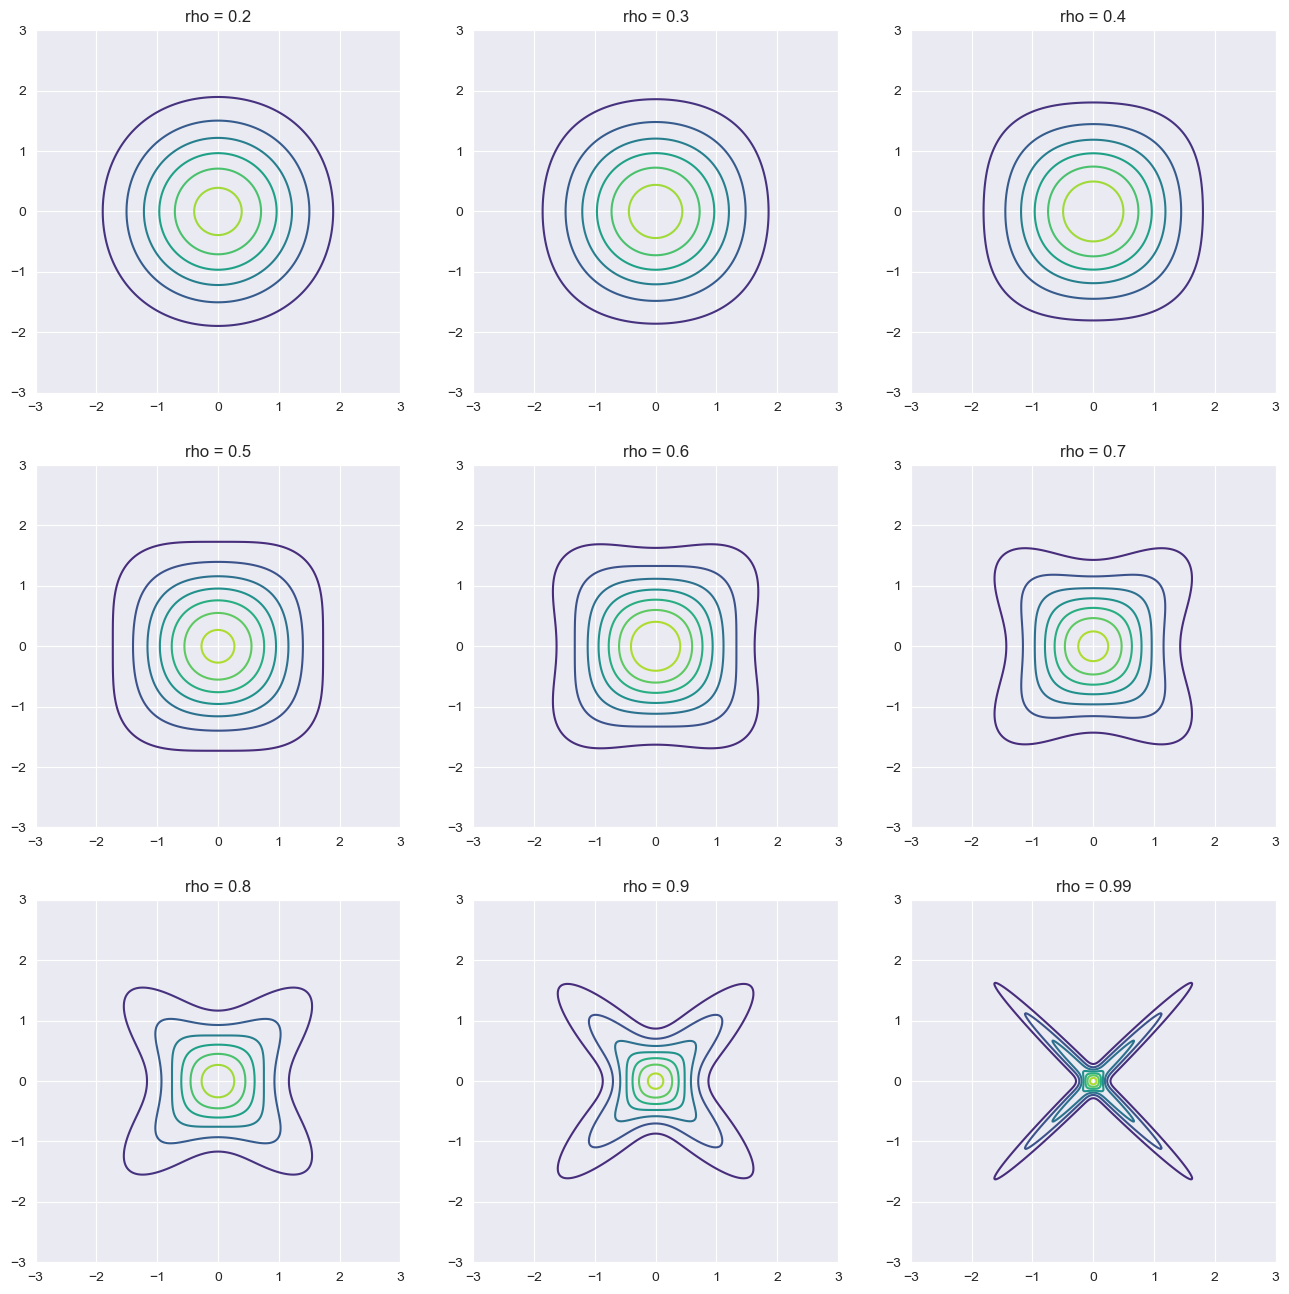

In [2]:
# Define the range for x and y
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)

# Define the mean and a
mean = np.array([0, 0])
p = 0.5

# Define the values of rho
rhos = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

# Create the subplots
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, rho in enumerate(rhos):
    # Define the covariance matrix
    cov1 = np.array([[1, rho], [rho, 1]])
    cov2 = np.array([[1, -rho], [-rho, 1]])

    # Create the multivariate normal mixture distribution
    smnm = simple_multivariate_normal_mixture(mean, cov1, mean, cov2, p)

    # Calculate the density
    Z = smnm.pdf(np.dstack((X, Y)))

    # Plot the isodensity
    ax = axs[i // 3, i % 3]
    ax.contour(X, Y, Z, cmap=cm.viridis)
    ax.set_title(f'rho = {rho}')

plt.show()

We generate the random numbers based on this simple binormal distribution and compute the mutual information and correlation via Monte Carlo. 
The marginal distribution of this binormal distirbution is simply standard normal by definition, so the mutual information can be calculated as
$$
\frac{1}{N}\sum_{i=1}^N \log \frac{f(x_i, y_i)}{\phi(x_i)\phi(y_i)}
$$
where $\phi$ is the standard normal pdf.

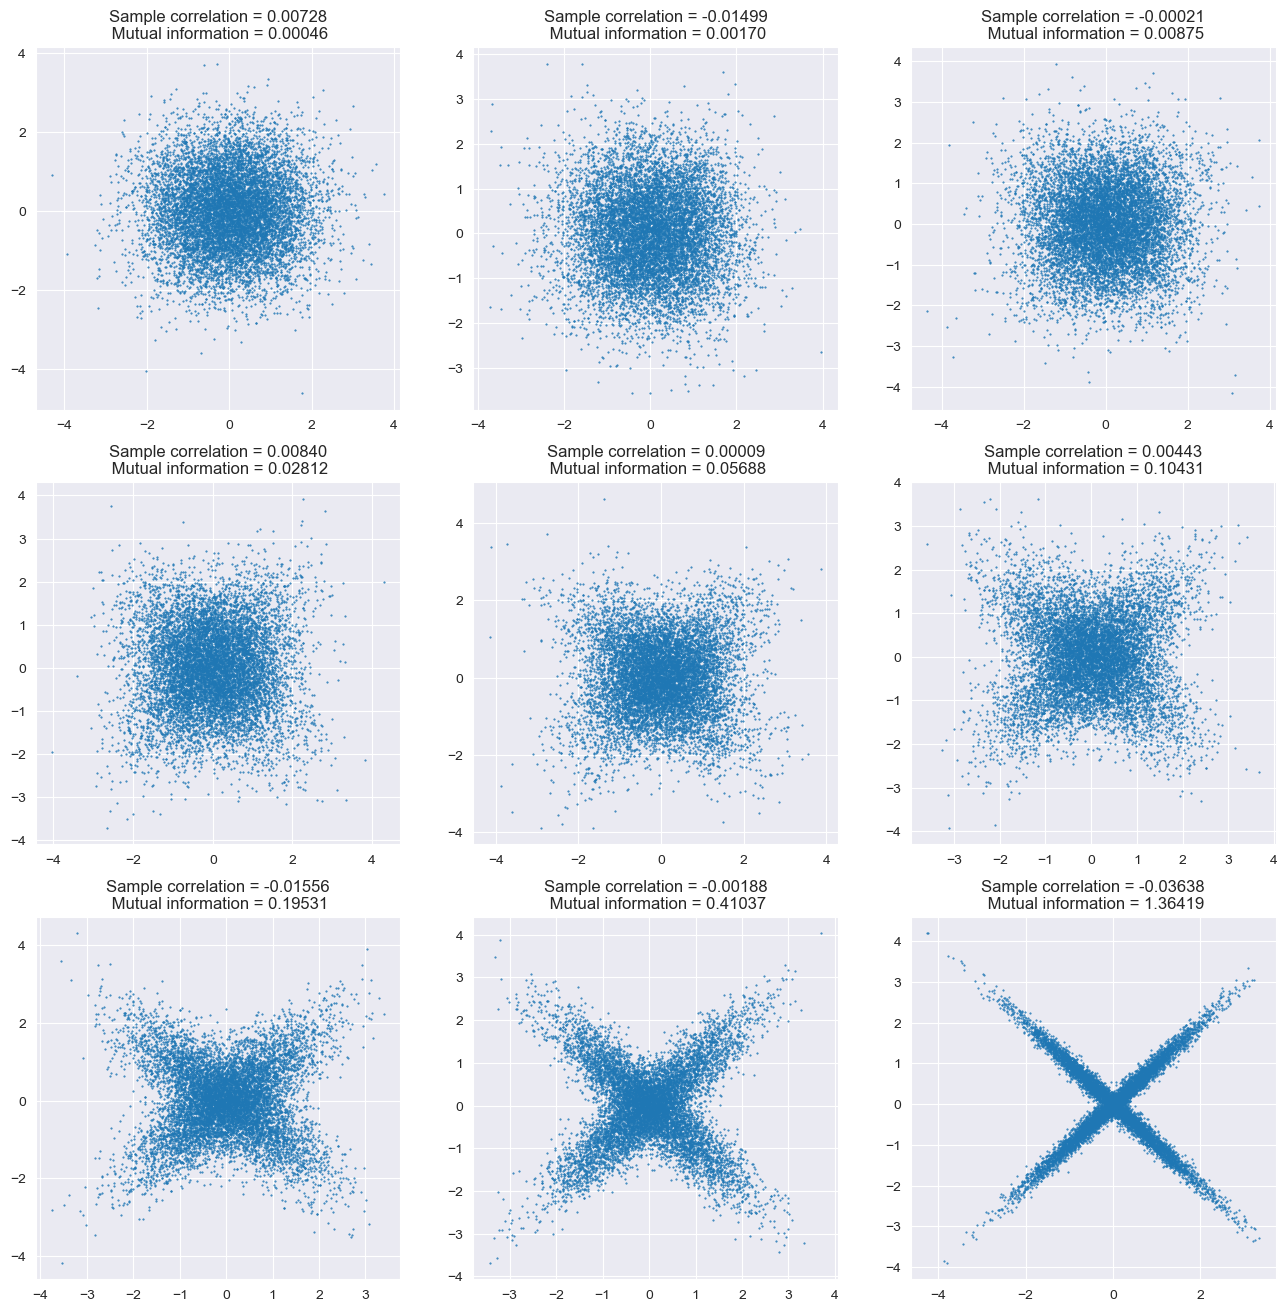

In [3]:
# Create the subplots
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, rho in enumerate(rhos):
    # Define the covariance matrix
    cov1 = np.array([[1, rho], [rho, 1]])
    cov2 = np.array([[1, -rho], [-rho, 1]])

    # Create the multivariate normal mixture distribution
    smnm = simple_multivariate_normal_mixture(mean, cov1, mean, cov2, p)
    sample = smnm.rvs(10000)
    sample_corr = np.corrcoef(sample[:, 0], sample[:, 1])[0, 1]
    mutual_info = np.mean(np.log(smnm.pdf(sample) / norm.pdf(sample[:, 0], loc=0, scale=1) / norm.pdf(sample[:, 1], loc=0, scale=1)))

    # Plot the isodensity
    ax = axs[i // 3, i % 3]
    ax.plot(sample[:, 0], sample[:, 1], '.', markersize=1)
    ax.set_title('Sample correlation = {0:.5f}'.format(sample_corr) + '\n Mutual information = {0:.5f}'.format(mutual_info))

plt.show()

The following figure compares the mutual information to correlation of the simple binormal distribution, as the correlation parameter $\rho$ increases. The sample correlation fails to capture the dependency between X and Y.

Text(0.5, 1.0, 'Mutual information vs sample correlation')

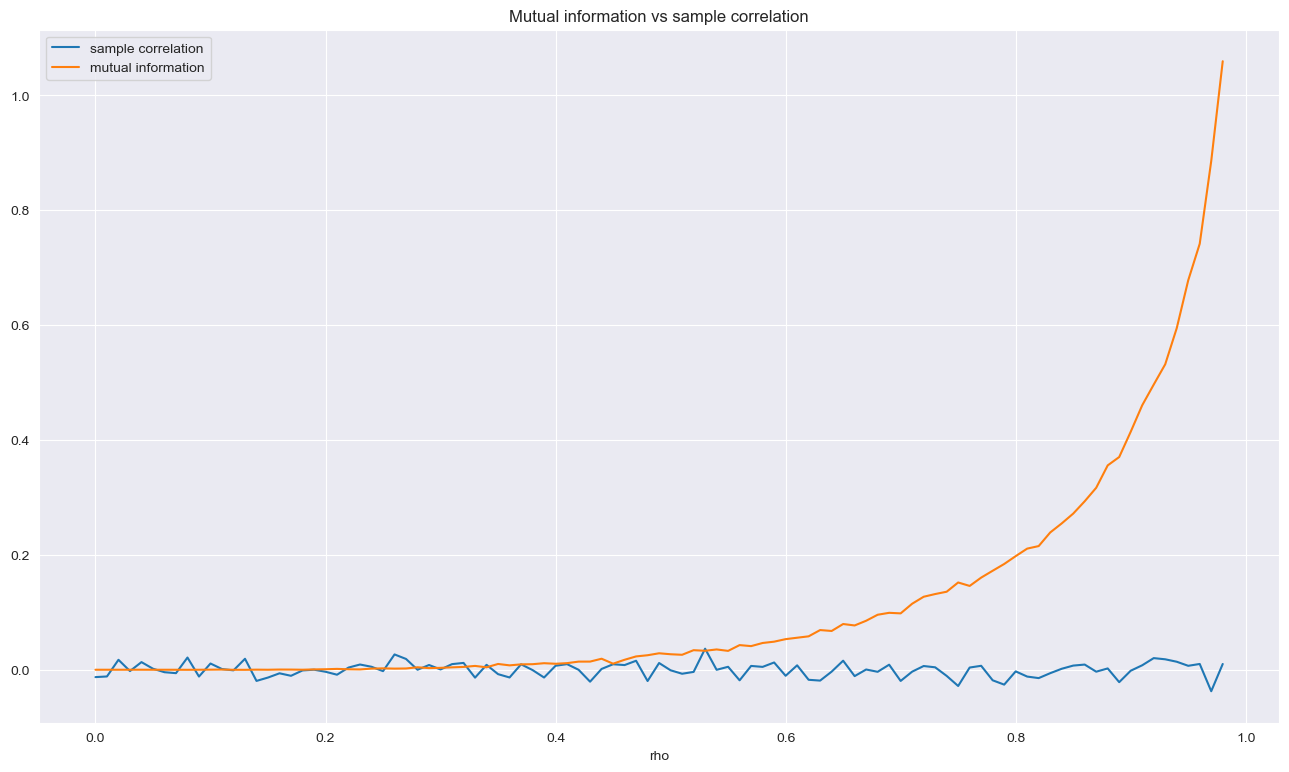

In [4]:
rhos = np.arange(0, 0.99, 0.01)
sample_corr = np.zeros(len(rhos))
mutual_info = np.zeros(len(rhos))

for i, rho in enumerate(rhos):
    # Define the covariance matrix
    cov1 = np.array([[1, rho], [rho, 1]])
    cov2 = np.array([[1, -rho], [-rho, 1]])

    # Create the multivariate normal mixture distribution
    smnm = simple_multivariate_normal_mixture(mean, cov1, mean, cov2, p)
    sample = smnm.rvs(10000)
    sample_corr[i] = np.corrcoef(sample[:, 0], sample[:, 1])[0, 1]
    mutual_info[i] = np.mean(np.log(smnm.pdf(sample) / norm.pdf(sample[:, 0], loc=0, scale=1) / norm.pdf(sample[:, 1], loc=0, scale=1)))
    
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(rhos, sample_corr, label='sample correlation')
ax.plot(rhos, mutual_info, label='mutual information')
ax.legend()
ax.set_xlabel("rho")
ax.set_title("Mutual information vs sample correlation")

# 6.5 Fat tails and random matrices, a rapid interlude

## Figure 6.9: The various shapes of the distribution of the eigenvalues for random matrices, which in the Gaussian case follow the Wigner semicircle distribution.

Here we also show the random matrices in heatmap, from which we can easily see the difference between a Gaussian random matrix (white noise) and a Cauchy matrix (a few extrme values dominates the headmap).
From the heatmap we can have a better understanding of the distribution of the eigenvalues. Consider a matrix with most zeros and only a few large positive/negative numbers, for example

$$
A = \begin{bmatrix}
0 & 1000 & 0 & 0 & 0 \\
1000 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$$

The heatmap of this matrix would be similar as the Cauchy 
Then the eigenalues are 1000 and -1000 with eigenvectors $[1/\sqrt{2}, -1/\sqrt{2}, 0, 0, 0]$ and $[-1/\sqrt{2}, 1/\sqrt{2}, 0, 0, 0]$. 

Adding some small pertubations to this matrix would create other three eigenvalues that are close to zero, which mimicks the case of Cauchy random matrix. 

Text(0.5, 1.0, 'Matrix B')

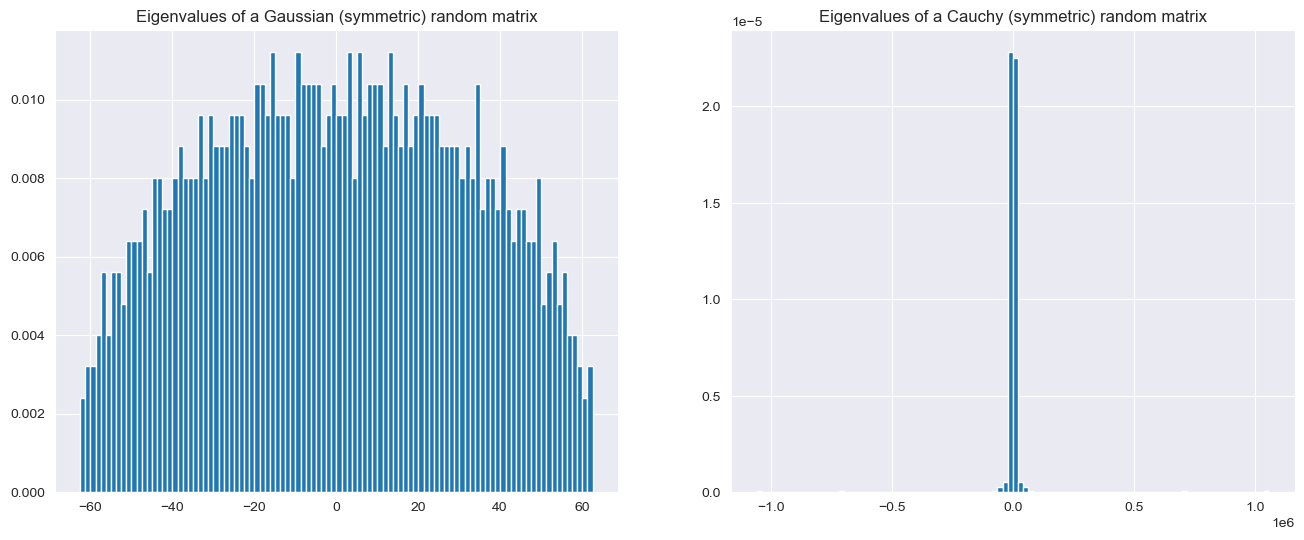

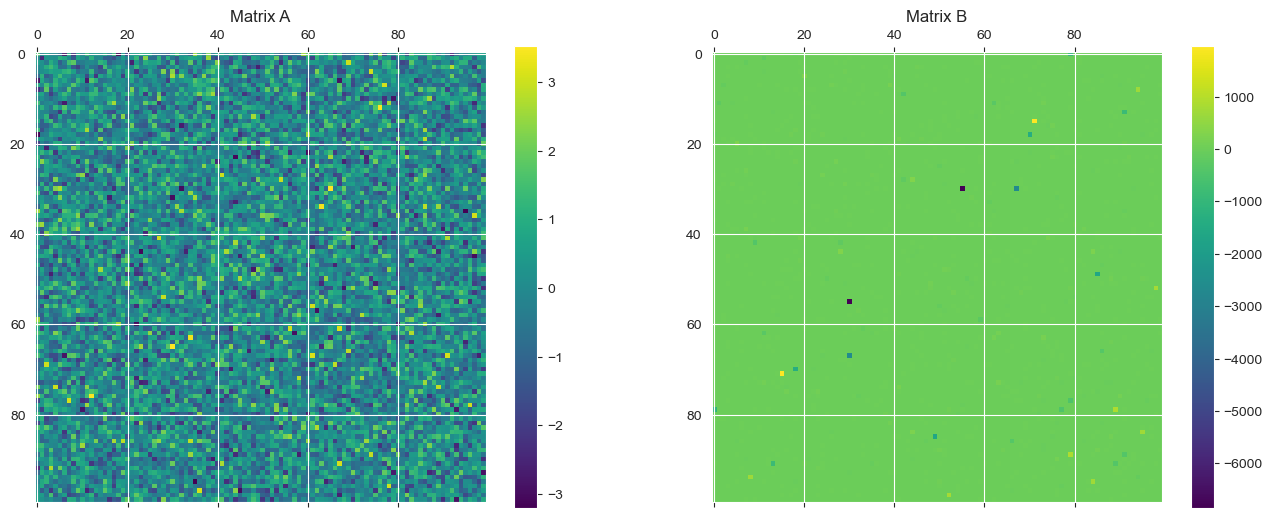

In [5]:
n = 1000

# Generate a random n x n matrix from a standard normal distribution
A = norm.rvs(size=(n, n), random_state=1)
B = cauchy.rvs(size=(n, n), random_state=1)

# Make the matrix symmetric by adding it to its transpose and zero out the diagonal
A = np.tril(A).T + np.tril(A, -1)
B = np.tril(B).T + np.tril(B, -1)
    
# Compute the eigenvalues
lambda_A = np.linalg.eigvalsh(A)
lambda_B = np.linalg.eigvalsh(B)

# Plotting eigenvalue histgrams
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(lambda_A, bins=100, density=True)
axs[0].set_title('Eigenvalues of a Gaussian (symmetric) random matrix')
axs[1].hist(lambda_B, bins=100, density=True)
axs[1].set_title('Eigenvalues of a Cauchy (symmetric) random matrix')

# Plotting the matrices as heatmaps
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
cax1 = axs[0].matshow(A[:100, :100], cmap='viridis')
fig.colorbar(cax1, ax=axs[0])
axs[0].set_title('Matrix A')
cax2 = axs[1].matshow(B[:100, :100], cmap='viridis')
fig.colorbar(cax2, ax=axs[1])
axs[1].set_title('Matrix B')


# 6.6 correlation and undefined variance

## Figure 6.11 IQ-Income regression
We use IQ-Income data from https://researchers.wls.wisc.edu/data/survey-data/. We pick the following two columns for regression:
* ghnrs_j: AD Raw Henmon-Nelson test score from junior year (IQ test)
* z_ar025rpc: Net worth based on direct reports (looks like to be more fat tailed than one year income data)

First we run the simple regression on the two columns.

In [6]:
# IQ income data 
iq_income = pd.read_csv('../data/wls_iq_income.csv')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     46.45
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.22e-11
Time:                        18:32:18   Log-Likelihood:                -33254.
No. Observations:                2123   AIC:                         6.651e+04
Df Residuals:                    2121   BIC:                         6.652e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.192e+05   1.76e+05     -2.386      0.017   -7.64e+05   -7.46e+04
x1          2.058e+04   3018.899      6.816      0.000    1.47e+04    2.65e+04
==============================================================================
Omnibus:                     3567.218   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2882145.779
Skew:                          11.122   Prob(JB):                         0.00
Kurtosis:                     182.129   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'P(X > x)')

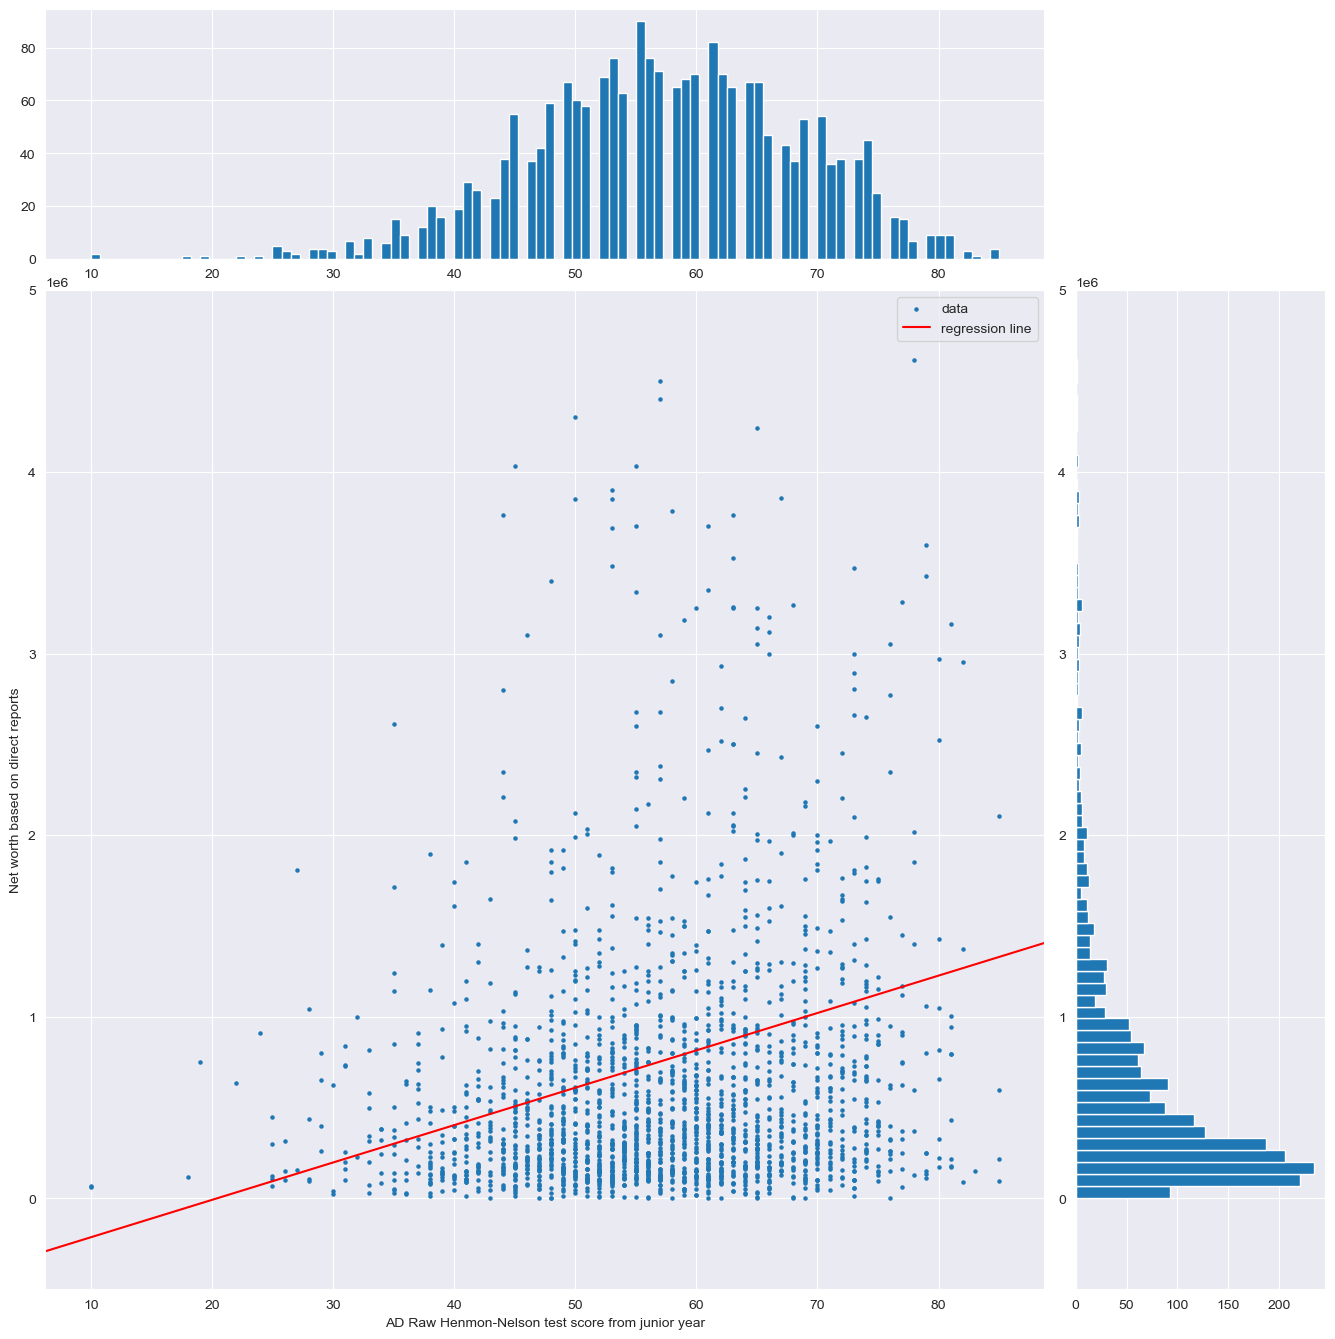

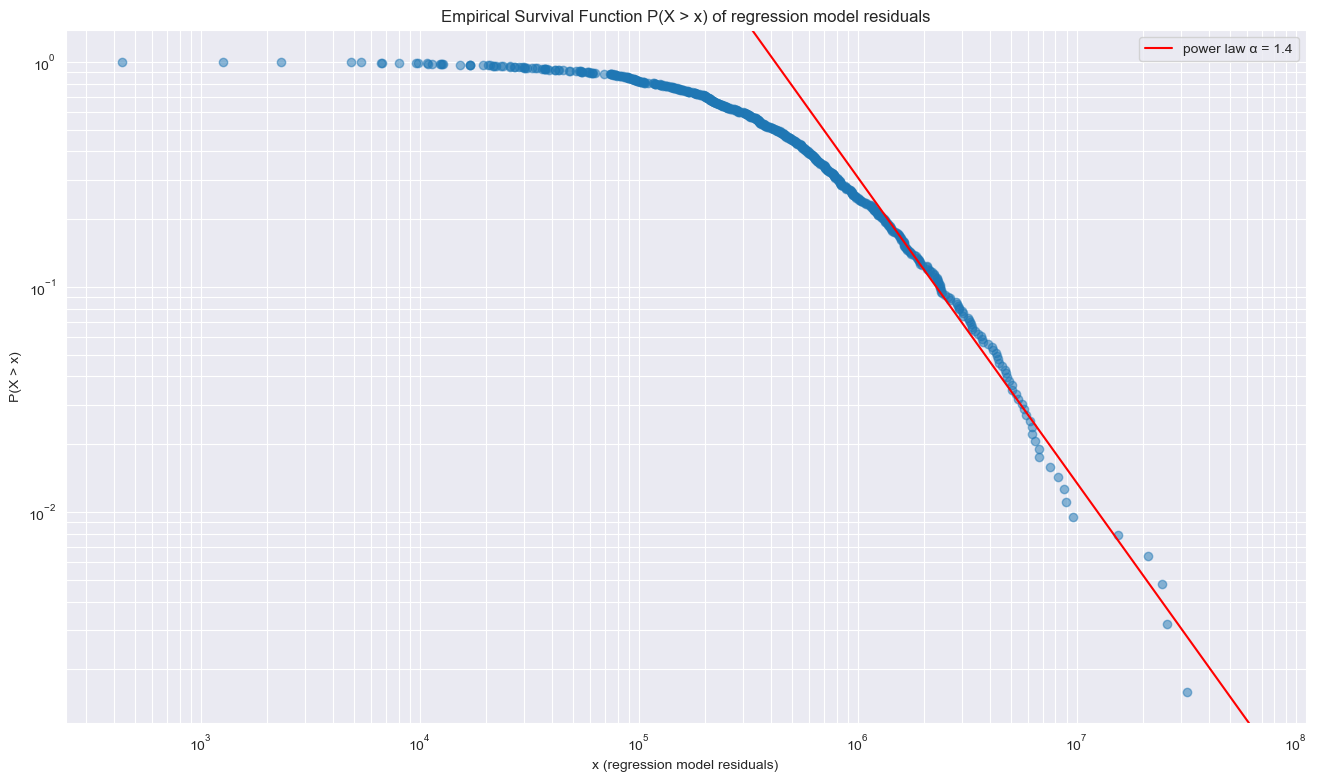

In [7]:
# Linear regression
y = iq_income['z_ar025rpc'].values
x = iq_income['ghnrs_j'].values
x = sm.add_constant(x)  # adding a constant

model = sm.OLS(y, x).fit()
alpha, beta = model.params
display(model.summary())

# Generate scatter-histogram plot
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(x[:,1], y, s=5.0)
ax_histx.hist(x[:,1], bins=100)
ax_histy.hist(y, bins=500, orientation='horizontal')

xlim = np.array(ax.get_xlim())
ax.plot(xlim, alpha + beta * xlim, 'r-')
ax.set_xlim(xlim)
ax.set_ylim([-5e5, 5e6])
ax.legend(['data', 'regression line'])
ax.set_xlabel("AD Raw Henmon-Nelson test score from junior year")
ax.set_ylabel("Net worth based on direct reports")

# Fit survival function of model residuals
pl = PowerLawEmpirical().fit(model.resid)

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.set_title('Empirical Survival Function P(X > x) of regression model residuals')
ax.set_xlabel('x (regression model residuals)')
ax.set_ylabel('P(X > x)')

## Would logrithm save the regression?
Taking the logrithm of income data before running the regression seems to be a better idea. The R2 is still very low 3.8%, but the t-test indicates the "statistical significance" of the slope (i.e. correlation).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     84.39
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           9.39e-20
Time:                        18:32:21   Log-Likelihood:                -3264.9
No. Observations:                2123   AIC:                             6534.
Df Residuals:                    2121   BIC:                             6545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7135      0.129     90.937      0.000      11.461      11.966
x1             0.0203      0.002      9.186      0.000       0.016       0.025
==============================================================================
Omnibus:                      193.643   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.916
Skew:                          -0.473   Prob(JB):                    1.06e-124
Kurtosis:                       5.358   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'log Net worth based on direct reports')

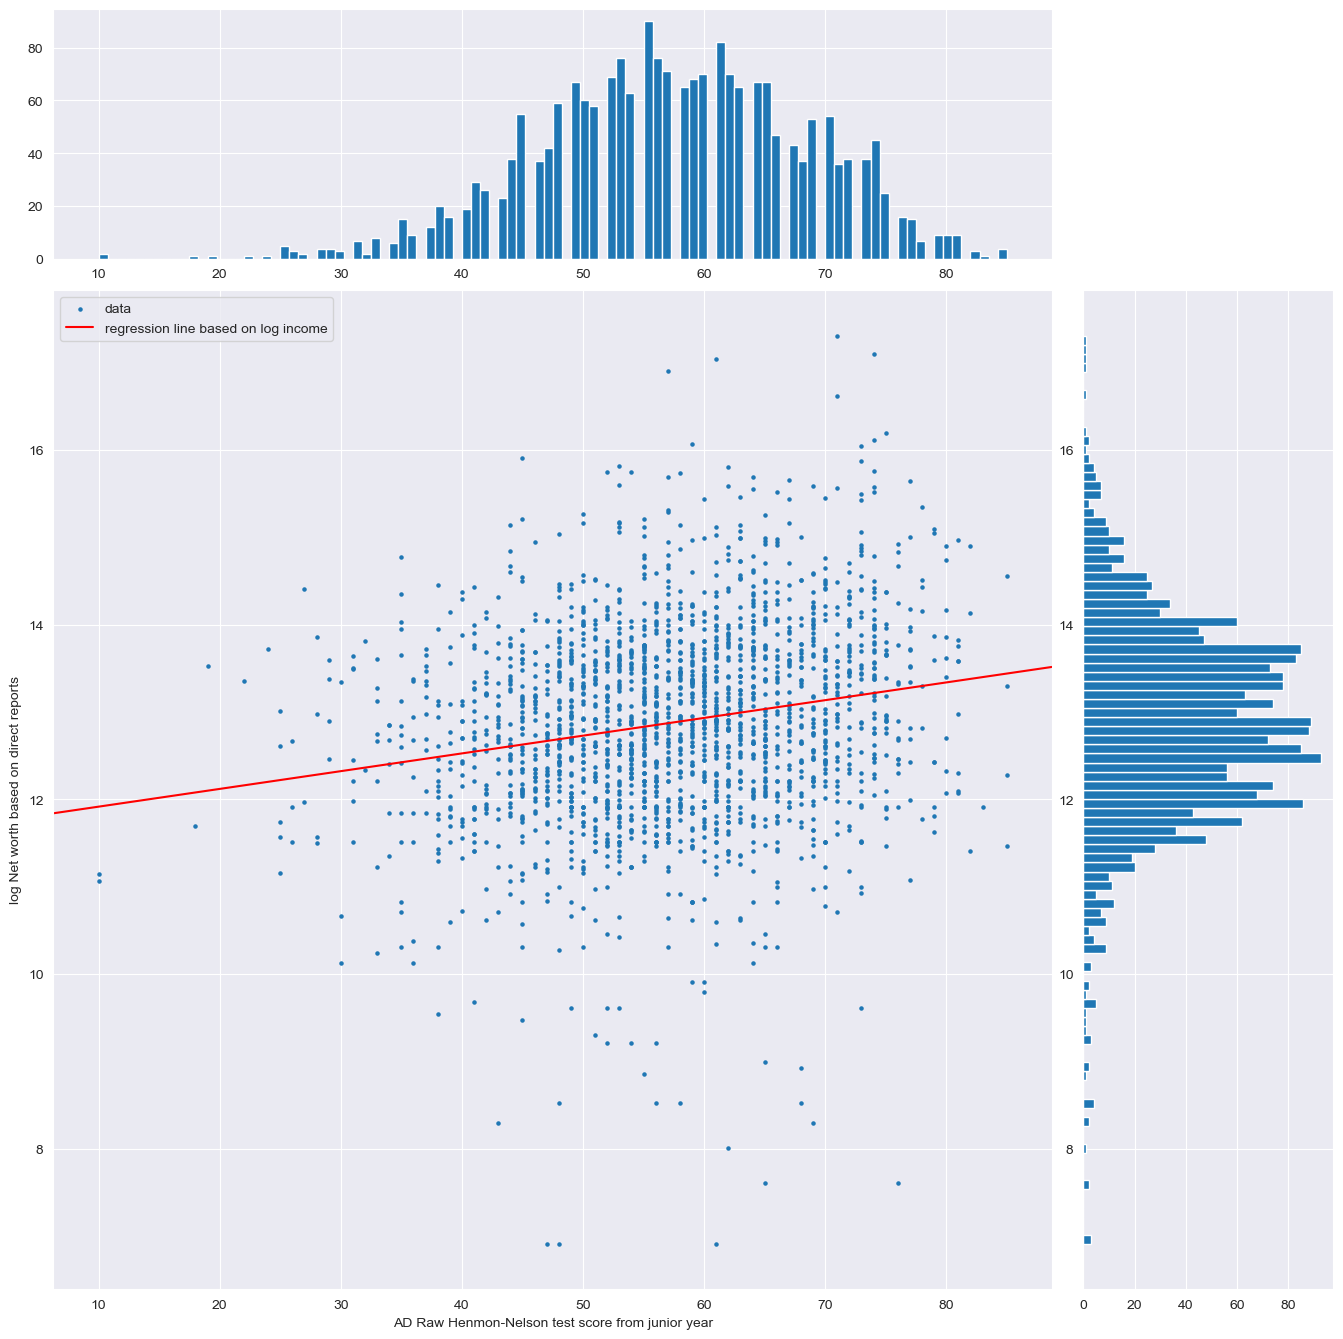

In [8]:
# Linear regression
y = iq_income['z_ar025rpc'].values
x = iq_income['ghnrs_j'].values
x = sm.add_constant(x)  # adding a constant

model = sm.OLS(np.log(y), x).fit()
alpha, beta = model.params
display(model.summary())

# Generate scatter-histogram plot
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(x[:,1], np.log(y), s=5.0)
ax_histx.hist(x[:,1], bins=100)
ax_histy.hist(np.log(y), bins=100, orientation='horizontal')

xlim = np.array(ax.get_xlim())
ax.plot(xlim, alpha + beta * xlim, 'r-')
ax.set_xlim(xlim)
# ax.set_ylim([-5e5, 5e6])
ax.legend(['data', 'regression line based on log income'])
ax.set_xlabel("AD Raw Henmon-Nelson test score from junior year")
ax.set_ylabel("log Net worth based on direct reports")

Using logrithm corresponds to a non-linear regression line if we convert the log plot back to raw income scatter plot. However the this convex line still fails to capture most of the tails in income data, as the residual still has the power law of 1.5, slightly better than the previous linear regression. 

Text(0, 0.5, 'P(X > x)')

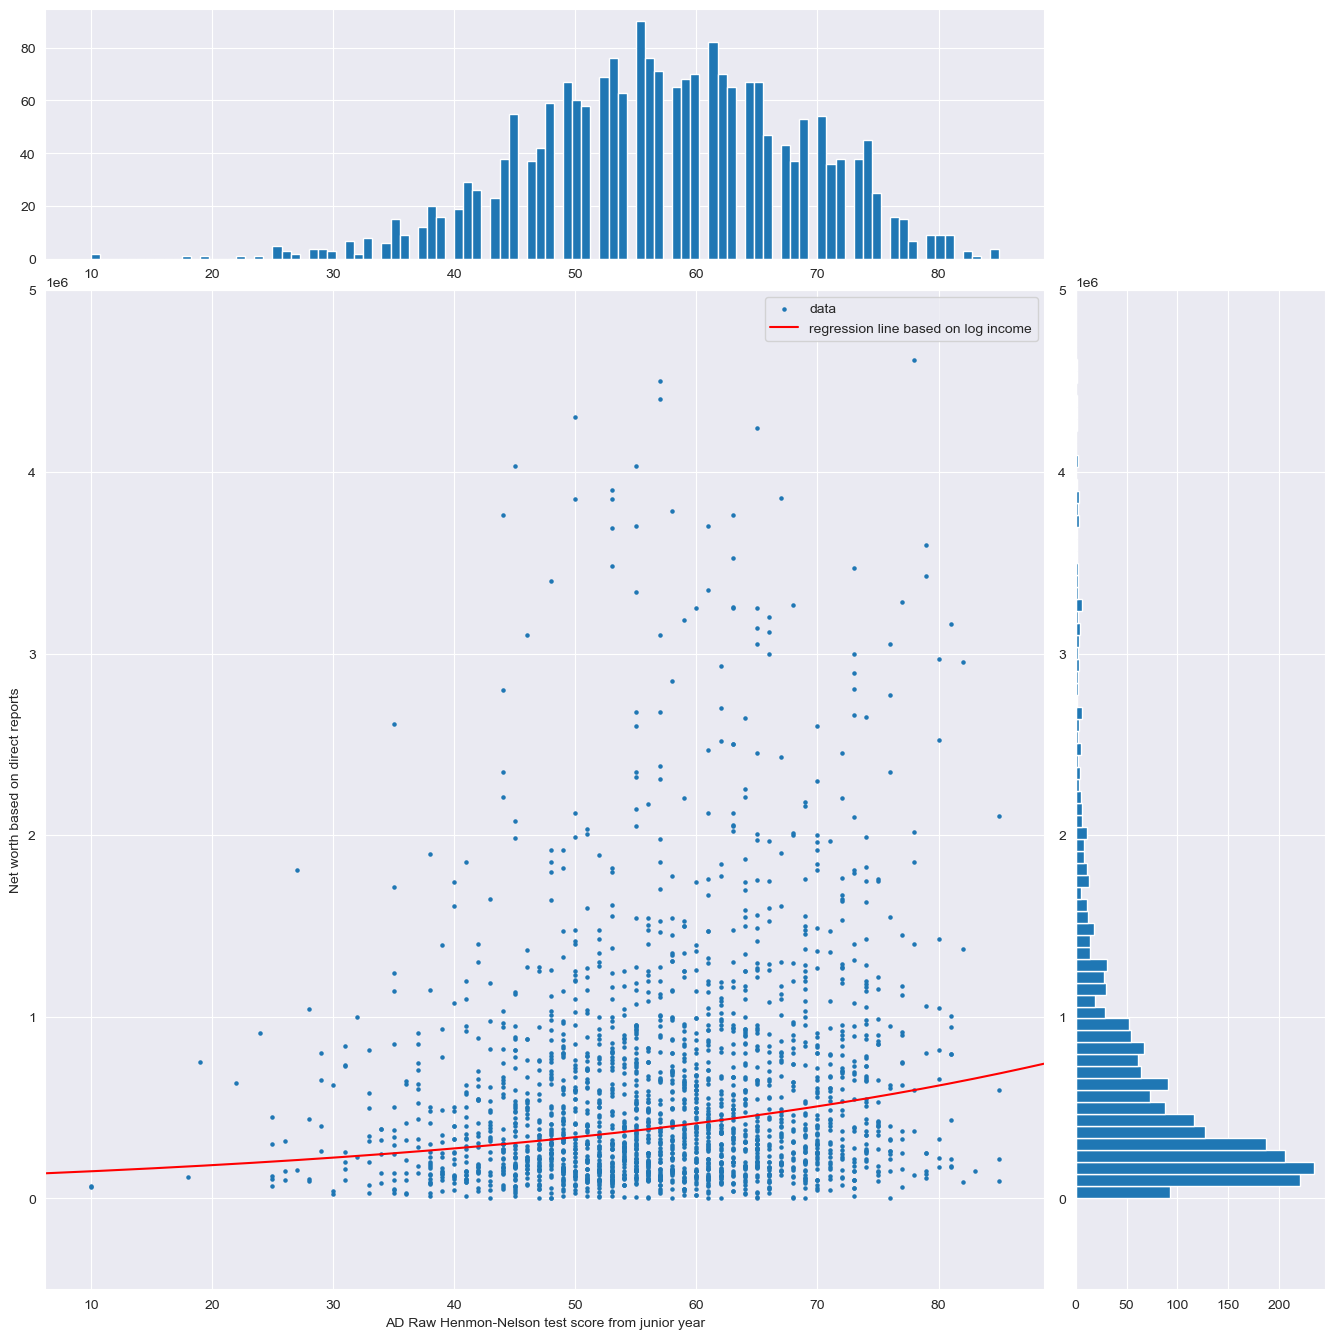

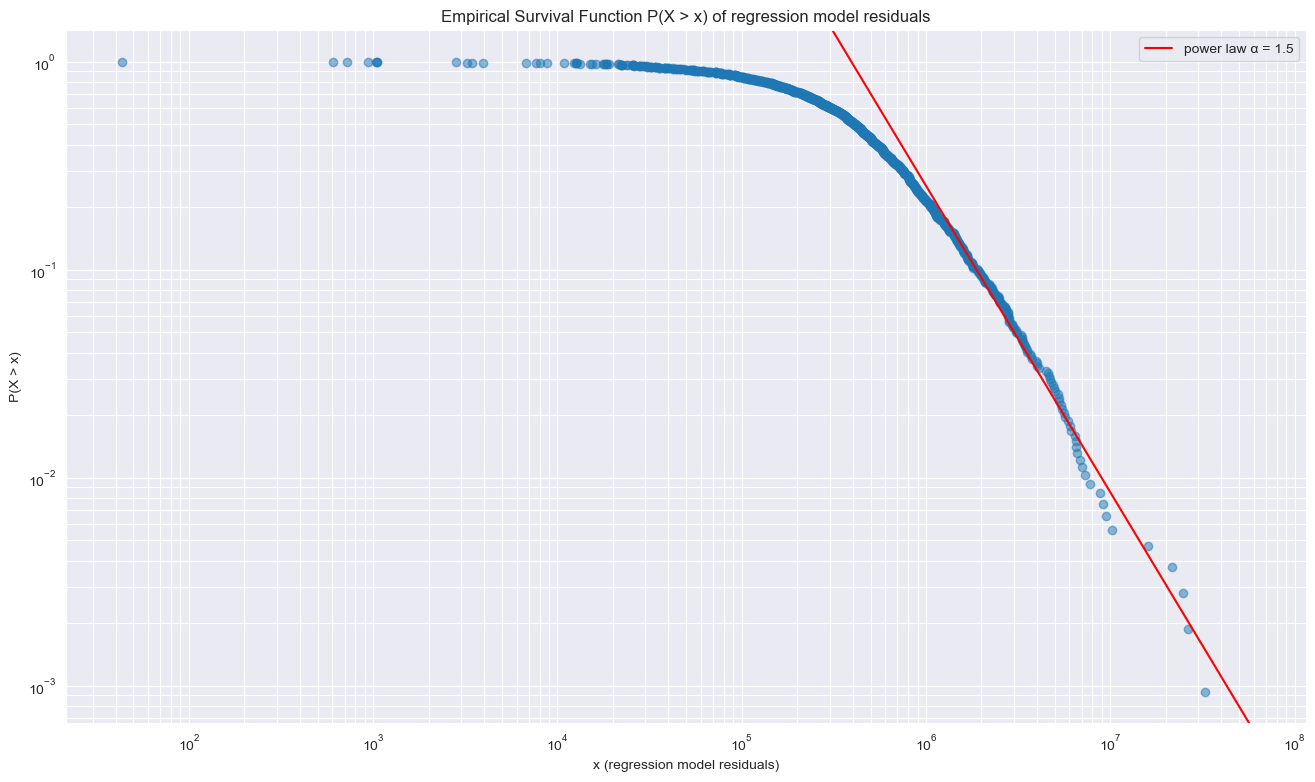

In [9]:
# Generate scatter-histogram plot
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(x[:,1], y, s=5.0)
ax_histx.hist(x[:,1], bins=100)
ax_histy.hist(y, bins=500, orientation='horizontal')

xlim = np.array(ax.get_xlim())
xline = np.linspace(xlim[0], xlim[1], 1000)
ax.plot(xline, np.exp(alpha + beta * xline), 'r-')
ax.set_xlim(xlim)
ax.set_ylim([-5e5, 5e6])
ax.legend(['data', 'regression line based on log income'])
ax.set_xlabel("AD Raw Henmon-Nelson test score from junior year")
ax.set_ylabel("Net worth based on direct reports")

# Fit survival function of model residuals
pl = PowerLawEmpirical().fit(y - np.exp(model.predict(x)))

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.set_title('Empirical Survival Function P(X > x) of regression model residuals')
ax.set_xlabel('x (regression model residuals)')
ax.set_ylabel('P(X > x)')

## Would copula save the regression
We can make it slightly better (R2 4% and power law 1.6) by using a copula approach: fitting the income data by a Pareto distribution and using inverse CDF to convert it to a "Gaussian" random variable. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     87.89
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.72e-20
Time:                        18:32:25   Log-Likelihood:                -2808.4
No. Observations:                2123   AIC:                             5621.
Df Residuals:                    2121   BIC:                             5632.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8999      0.104     -8.662      0.000      -1.104      -0.696
x1             0.0167      0.002      9.375      0.000       0.013       0.020
==============================================================================
Omnibus:                      441.677   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6433.920
Skew:                          -0.556   Prob(JB):                         0.00
Kurtosis:                      11.456   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'P(X > x)')

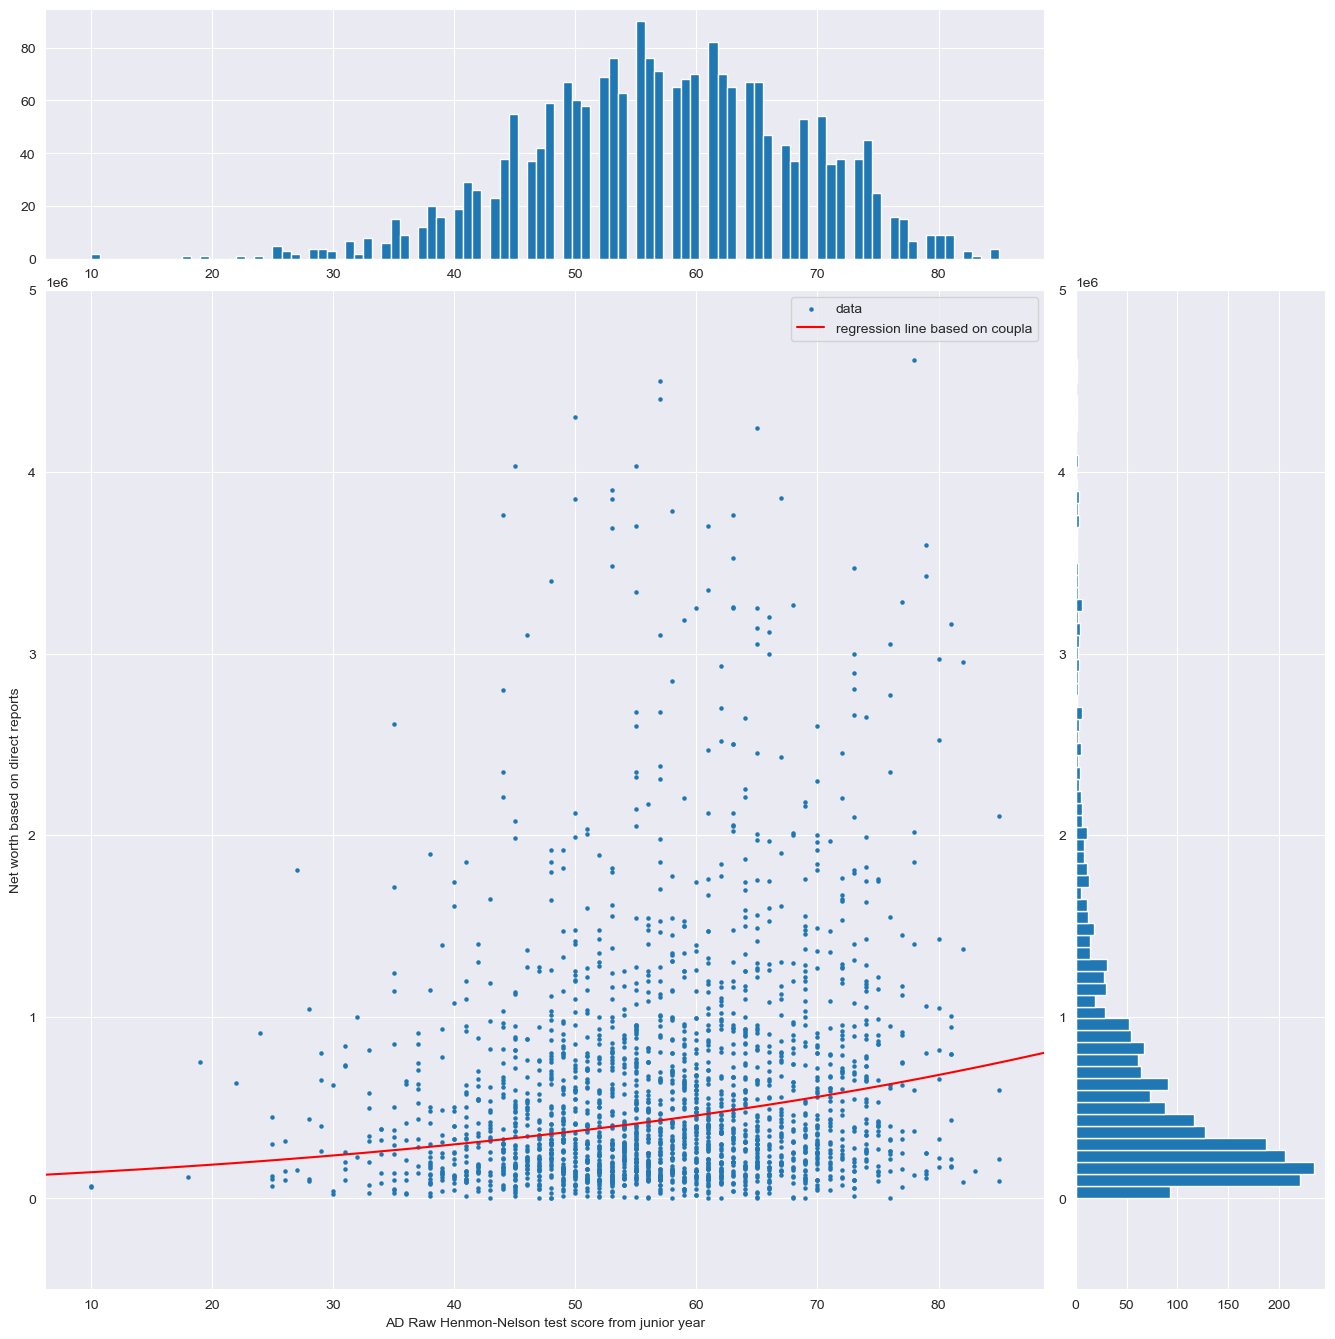

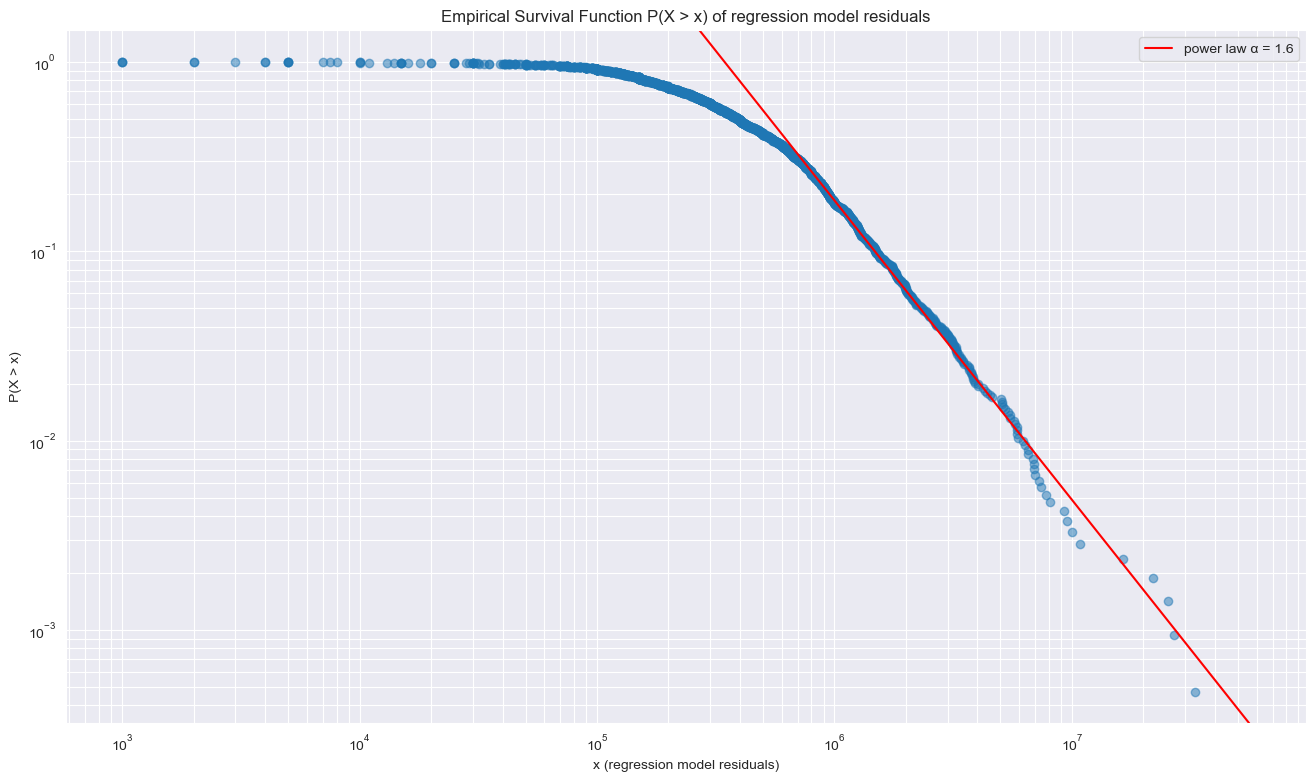

In [10]:
y = iq_income['z_ar025rpc'].values
b, loc, scale = pareto.fit(y)
y_norm = norm.ppf(pareto.cdf(y, b, loc, scale))

x = iq_income['ghnrs_j'].values
x = sm.add_constant(x)  # adding a constant

model = sm.OLS(y_norm, x).fit()
alpha, beta = model.params
display(model.summary())

# Generate scatter-histogram plot
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(x[:,1], y, s=5.0)
ax_histx.hist(x[:,1], bins=100)
ax_histy.hist(y, bins=500, orientation='horizontal')

xlim = np.array(ax.get_xlim())
x_line = np.linspace(xlim[0], xlim[1], 1000)
y_line = pareto.ppf(norm.cdf(alpha + beta * x_line), b, loc, scale)
ax.plot(x_line, y_line, 'r-')
ax.set_xlim(xlim)
ax.set_ylim([-5e5, 5e6])
ax.legend(['data', 'regression line based on coupla'])
ax.set_xlabel("AD Raw Henmon-Nelson test score from junior year")
ax.set_ylabel("Net worth based on direct reports")

# Fit survival function of model residuals
pl = PowerLawEmpirical().fit(y - np.exp(model.predict(x)))

fig, ax = plt.subplots(figsize=(16, 9))
pl.loglog_plot(ax=ax)
ax.set_title('Empirical Survival Function P(X > x) of regression model residuals')
ax.set_xlabel('x (regression model residuals)')
ax.set_ylabel('P(X > x)')